# Binomial Distribution

* likelihood: what parameter is likely to be to explain the observed data

## MLE

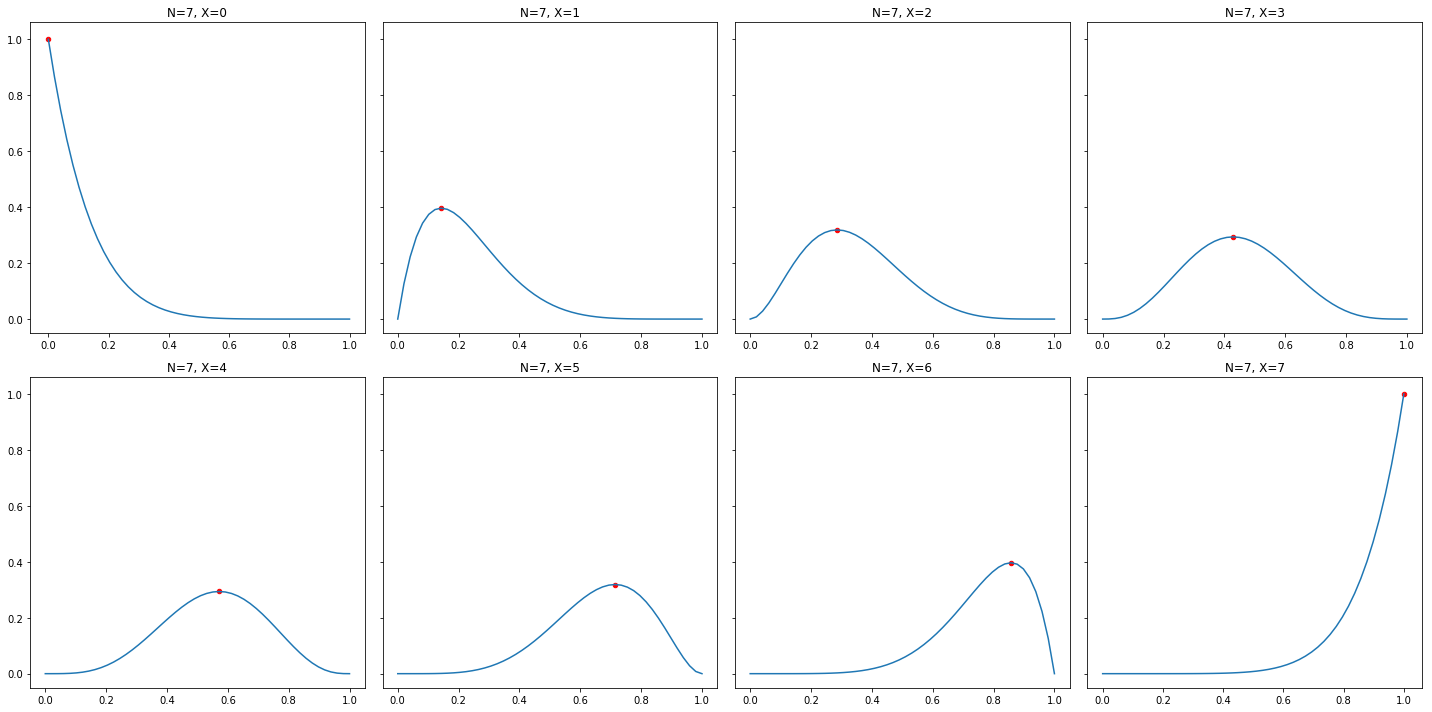

In [54]:
import numpy as np
from scipy.special import gamma
from scipy.special import comb
import matplotlib.pyplot as plt

def Binomial(theta, n, x):
    """
    theta: probability
    n: number of trials
    x: number of value that random variable X can be
    """
    return comb(n, x) * (theta**x) * (1-theta)**(n-x)

probs = np.linspace(0, 1, num=50)
N = 7
X = np.arange(0, N+1)

fig, axes = plt.subplots(2, (N+1)//2, figsize=(20, 10), sharey=True)
for x, ax in zip(X, axes.flatten()):
    L = Binomial(probs, N, x)
    max_y, max_x = L.max(), probs[L.argmax()]
    ax.plot(probs, L)
    ax.scatter(max_x, max_y, s=20, c="red")
    ax.set_title(f"N={N}, X={x}")
plt.tight_layout()
plt.show()


In [28]:
def Beta(theta, a, b):
    return gamma(a + b)/(gamma(a)*gamma(b)) * theta**(a-1) * (1-theta)**(b-1)

/home/simonjisu/miniconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


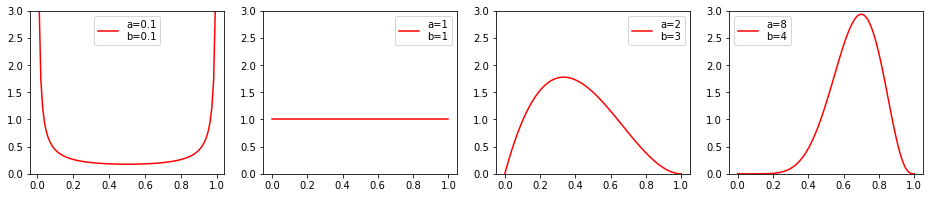

In [51]:
aa = [0.1, 1, 2, 8]
bb = [0.1, 1, 3, 4]
probs = np.linspace(0, 1, num=100)

fig, axes = plt.subplots(1, 4, figsize=(16, 3), sharey=False)
for ax, a, b in zip(axes, aa, bb):
    beta_value = Beta(probs, a, b)
    ax.plot(probs, beta_value, c="red", label=f"a={a}\nb={b}")
    ax.set_ylim(0, 3)
    ax.legend()

In [49]:
def Posterior(theta, m, l, a, b):
    return gamma(m+a+l+b)/(gamma(m+a)*gamma(l+b))*theta**(m+a-1)*(1-theta)**(l+b-1)

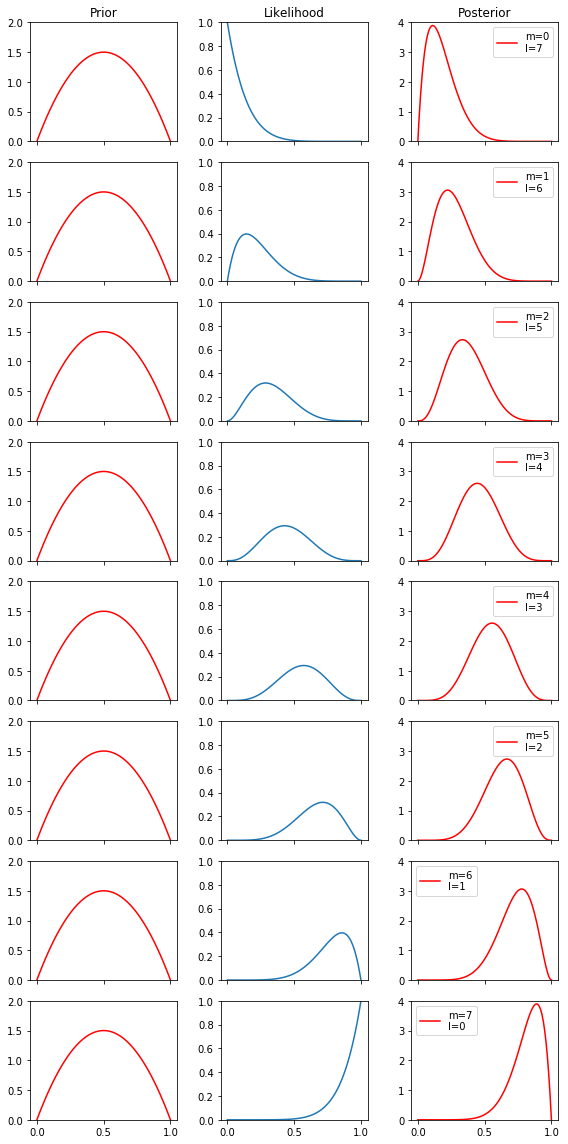

In [100]:
a, b = (2, 2)  # init hyperparameters

N = 7
X = np.arange(0, N+1)
probs = np.linspace(0, 1, num=100).reshape(-1, 1)
likelihood = Binomial(probs, N, X)
prior = Beta(probs, a, b)
post = Posterior(probs, X, N-X, a, b)

fig, axes = plt.subplots(N+1, 3, figsize=(8, 16), sharex=True, sharey=False)
for i, row_axes in enumerate(axes):
    if i == 0:
        row_axes[0].set_title("Prior")
        row_axes[1].set_title("Likelihood")
        row_axes[2].set_title("Posterior")
    row_axes[0].plot(probs, prior, c="red")
    row_axes[1].plot(probs, likelihood[:, i])
    row_axes[2].plot(probs, post[:, i], c="red", label=f"m={i}\nl={N-i}")
    row_axes[0].set_ylim(0, 2)
    row_axes[1].set_ylim(0, 1)
    row_axes[2].set_ylim(0, 4)
    row_axes[2].legend()
plt.tight_layout()
plt.show()

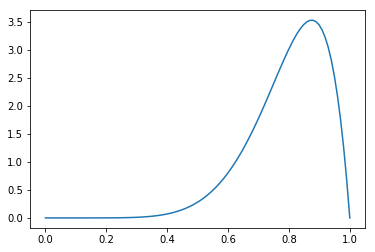

In [107]:
plt.plot(probs, Posterior(probs, 3, 0, 3+b, 0+b))

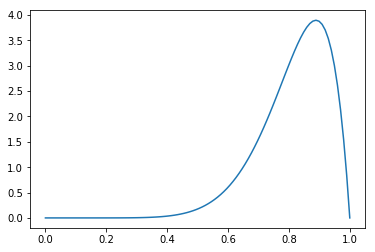

In [108]:
plt.plot(probs, post[:, -1])